In [1]:
# MA Cross Backtesting on 1H BTC with following trade costs and timeframes
# - Slippage is 0.5BPS
# - Taker fee is 0.04%
# - Initial capital is 10000.0$
# - Position size per trade is 2% of account
# - Timeframe is 1H
# 

In [2]:
import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import yfinance          as yf
import pandas            as pd
import numpy             as np
import quantstats        as qs
import matplotlib.pyplot as plt

In [3]:
df = yf.download('BTC-USD', interval='1h', period='23mo')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-11-02 05:00:00+00:00,61461.097656,61739.613281,61340.339844,61720.281250,61720.281250,0
2021-11-02 06:00:00+00:00,61780.238281,61781.007812,61594.007812,61744.117188,61744.117188,0
2021-11-02 07:00:00+00:00,61771.878906,61801.332031,61558.199219,61595.171875,61595.171875,0
2021-11-02 08:00:00+00:00,61560.261719,61812.636719,61440.664062,61739.621094,61739.621094,0
2021-11-02 09:00:00+00:00,61651.304688,63111.089844,61551.183594,63111.089844,63111.089844,1297960960
...,...,...,...,...,...,...
2023-10-02 01:00:00+00:00,27936.640625,27962.277344,27837.687500,27919.294922,27919.294922,407851008
2023-10-02 02:00:00+00:00,27920.888672,28001.859375,27915.492188,27990.683594,27990.683594,322618368
2023-10-02 03:00:00+00:00,27990.007812,28143.666016,27966.824219,28103.494141,28103.494141,636149760


<Axes: xlabel='Datetime'>

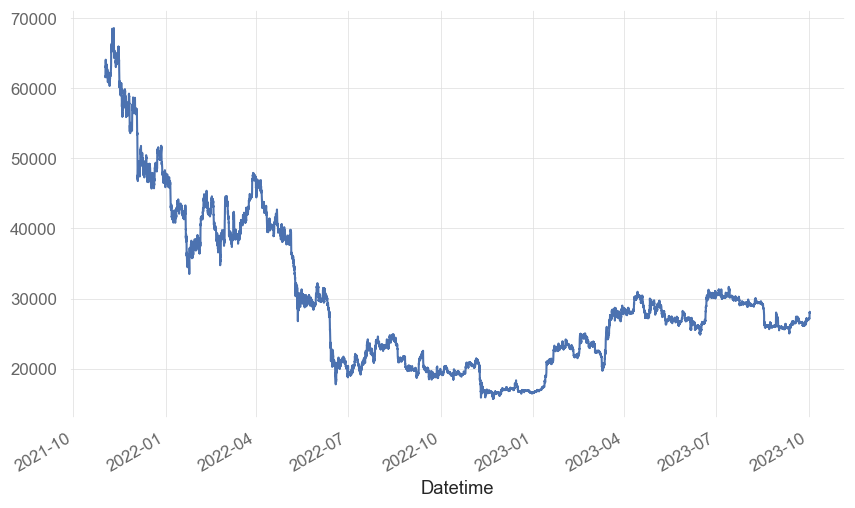

In [4]:
df['Close'].plot()

In [5]:
# Signal extraction

df['MA50' ] = df['Close'].rolling(window=50 ).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

df['Signal'] = 0
df.loc[((df['MA50'] > df['MA200']) & (df['MA50'].shift(1) <= df['MA200'].shift(1))), 'Signal'] =  1
df.loc[((df['MA50'] < df['MA200']) & (df['MA50'].shift(1) >= df['MA200'].shift(1))), 'Signal'] = -1

In [6]:
df['Signal'].value_counts()

Signal
 0    16624
-1       60
 1       60
Name: count, dtype: int64

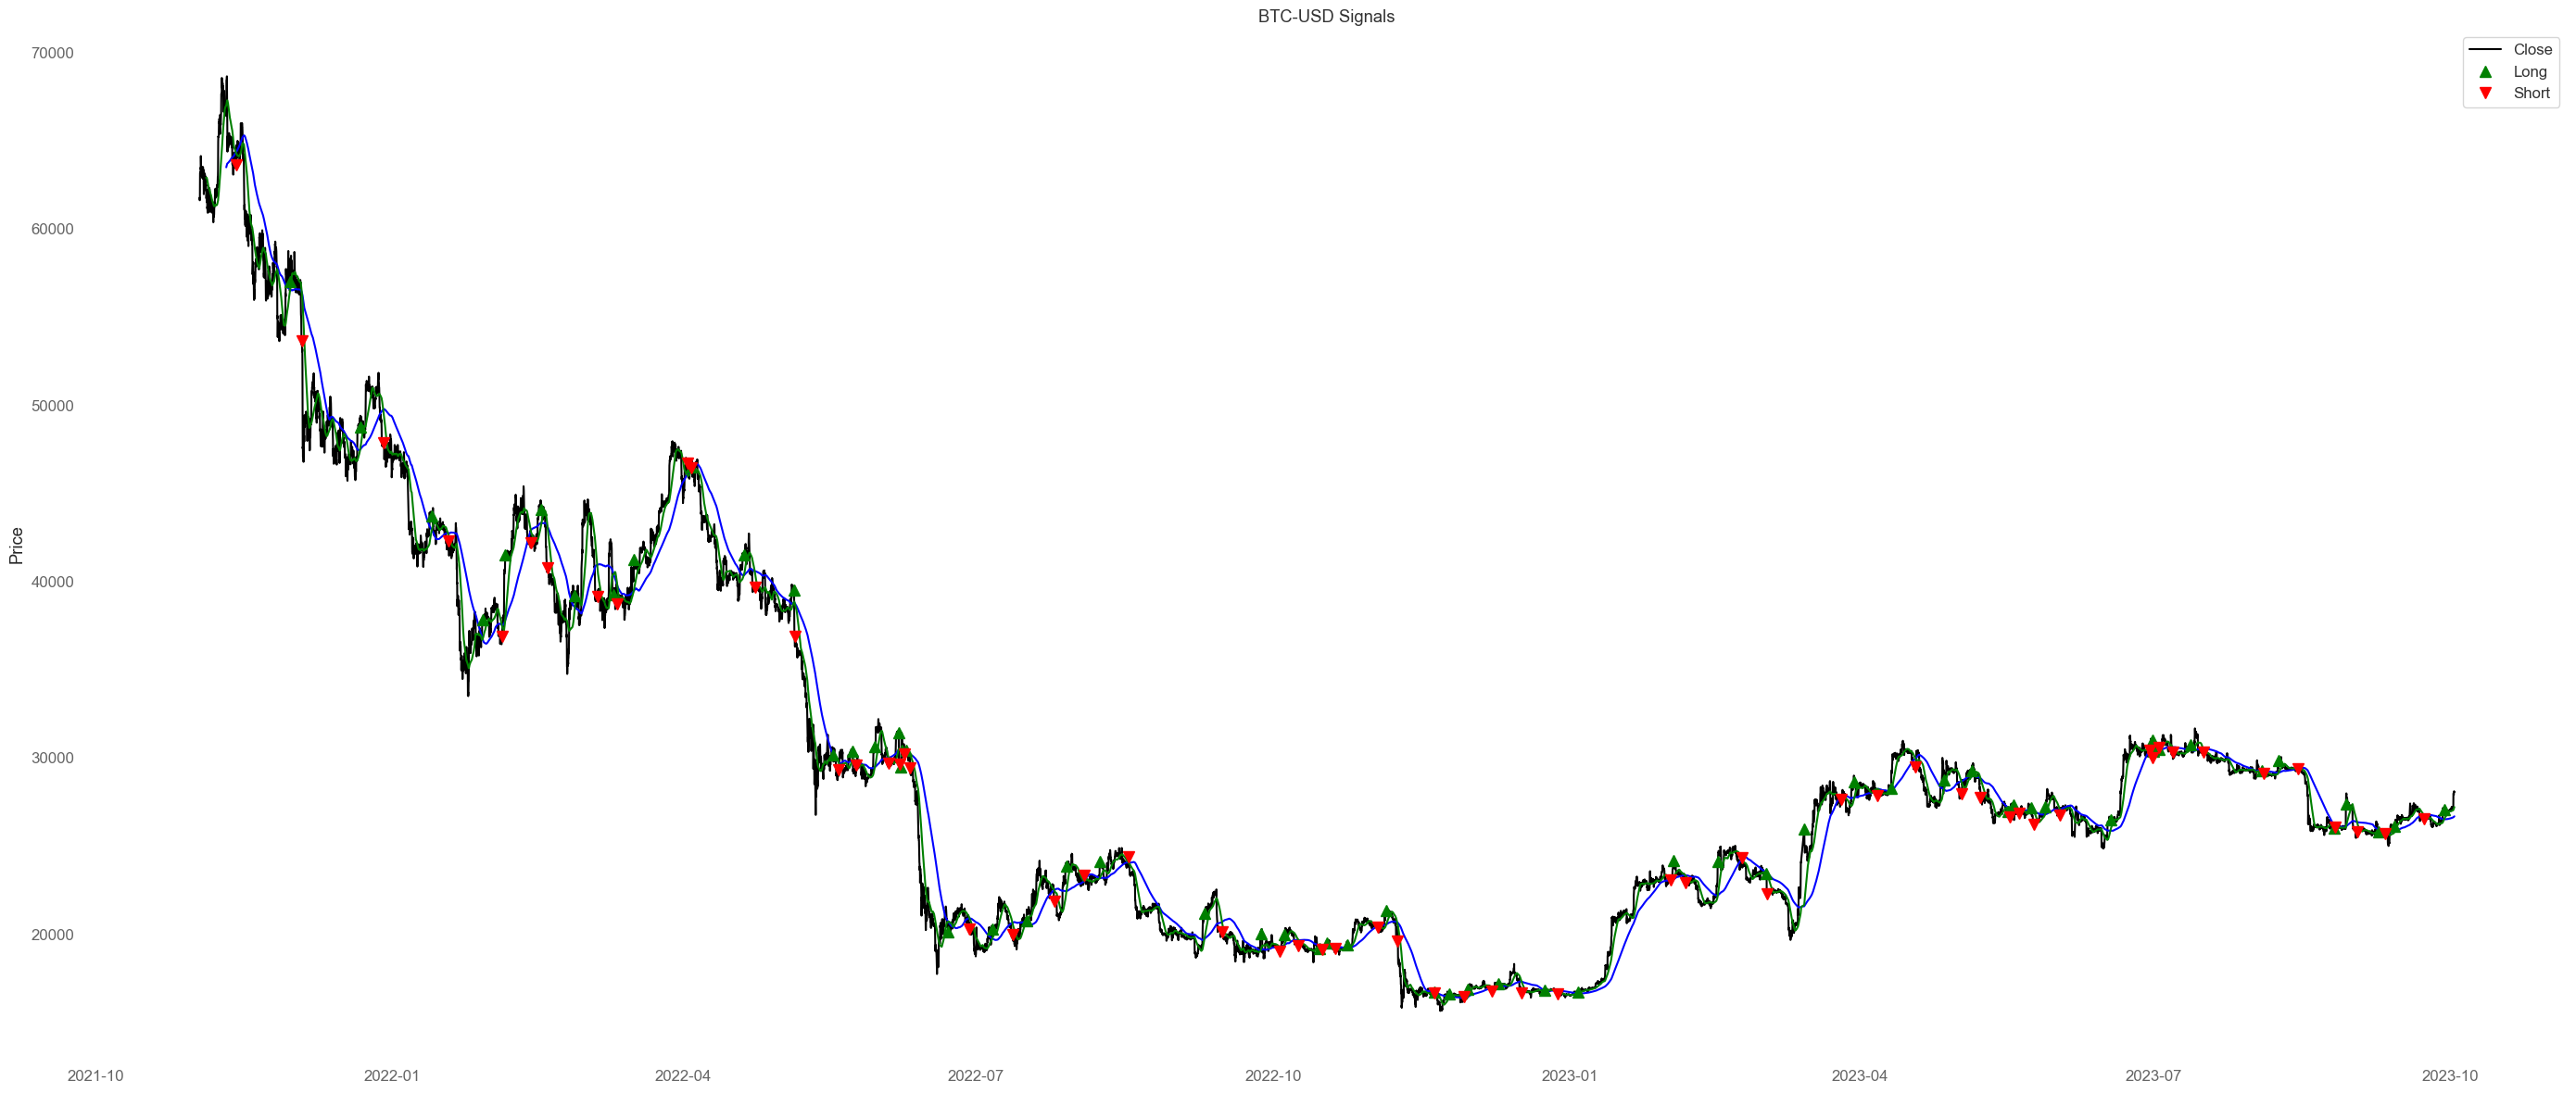

In [7]:
plot_df = df["2021-01-01":]

fig, ax1 = plt.subplots(1, figsize=(28, 12), sharex=True)

ax1.plot(plot_df.index, plot_df['Close'], label='Close', color='black')
ax1.plot(plot_df['MA200'], color='blue' )
ax1.plot(plot_df['MA50' ], color='green')
ax1.plot(plot_df[plot_df['Signal'] ==  1].index, plot_df[plot_df['Signal'] ==  1]['Close'], '^', markersize=8, color='green', label='Long' )
ax1.plot(plot_df[plot_df['Signal'] == -1].index, plot_df[plot_df['Signal'] == -1]['Close'], 'v', markersize=8, color='red'  , label='Short')
ax1.set_ylabel('Price')
ax1.set_title('BTC-USD Signals')
ax1.legend()
ax1.grid()

plt.tight_layout()
plt.show()

In [8]:
# Position tracking with slippage

slippage_bps     = 0.5 / 10000 # 0.5BPS
position         = 0
entry_timestamp  = None
entry_price      = 0
exit_timestamp   = None
exit_price       = 0
position_history = []

for index, row in df.iterrows():
    if row['Signal'] != position:
        # Exit position
        if position != 0:
            exit_timestamp = index
            exit_price     = row['Close'] * (1 - slippage_bps) if position == 1 else row['Close'] * (1 + slippage_bps)
            pct_change     = (exit_price - entry_price) / entry_price * 100
            position_history.append((entry_timestamp, exit_timestamp, entry_price, exit_price, pct_change))
        # Enter new position
        if row['Signal'] == 1:
            entry_timestamp = index
            entry_price     = row['Close'] * (1 + slippage_bps)
        elif row['Signal'] == -1:
            entry_timestamp = index
            entry_price     = row['Close'] * (1 - slippage_bps)
        position = row['Signal']

position_df = pd.DataFrame(position_history, columns=['Entry Time', 'Exit Time', 'Entry Price', 'Exit Price', 'Pct Change'])
position_df['cumret'] = position_df['Pct Change'].cumsum()

In [9]:
initial_capital    = 10000.0 # Initial capital in dollars
commission_fee     = 0.04    # 0.04% commission fee per trade
position_per_trade = 0.02    # 2% of position size per trade

account_balance = initial_capital
balance_changes = []

# Iterate through each trade in the position history
for index, trade in position_df.iterrows():
    pct_change       = trade['Pct Change']
    position_size    = account_balance * position_per_trade
    dollar_change    = position_size * pct_change
    commission       = position_size * (commission_fee/100.0)
    balance_change   = dollar_change - commission
    account_balance += balance_change
    balance_changes.append(balance_change)

position_df['Balance Change'] = balance_changes
position_df['Account History'] = initial_capital + position_df['Balance Change'].cumsum()

position_df['Entry Time'] = pd.to_datetime(position_df['Entry Time'])
position_df = position_df.set_index('Entry Time')

position_df['Account Change'] = position_df['Account History'].pct_change()

In [10]:
position_df

,Exit Time,Entry Price,Exit Price,Pct Change,cumret,Balance Change,Account History,Account Change
Entry Time,,,,,,,,
2021-11-13 12:00:00+00:00,2021-11-13 13:00:00+00:00,63592.371004,63542.618378,-0.078237,-0.078237,-15.727357,9984.272643,NaN
2021-11-30 08:00:00+00:00,2021-11-30 09:00:00+00:00,56983.220112,56809.632033,-0.304630,-0.382867,-60.910087,9923.362556,-0.006101
2021-12-03 23:00:00+00:00,2021-12-04 00:00:00+00:00,53613.866048,53141.477254,-0.881094,-1.263961,-174.947779,9748.414777,-0.017630
2021-12-22 00:00:00+00:00,2021-12-22 01:00:00+00:00,48749.999878,48821.824412,0.147332,-1.116629,28.647155,9777.061932,0.002939
2021-12-29 04:00:00+00:00,2021-12-29 05:00:00+00:00,47846.978625,47935.318521,0.184630,-0.931999,36.024570,9813.086502,0.003685
...,...,...,...,...,...,...,...,...
2023-09-08 18:00:00+00:00,2023-09-08 19:00:00+00:00,25792.914581,25874.973765,0.318146,-11.682295,49.303837,7807.670949,0.006355
2023-09-10 17:00:00+00:00,2023-09-10 18:00:00+00:00,25688.375673,25725.333077,0.143868,-11.538427,22.403050,7830.073999,0.002869
2023-09-13 18:00:00+00:00,2023-09-13 19:00:00+00:00,26117.467917,26159.565003,0.161184,-11.377243,25.178956,7855.252955,0.003216


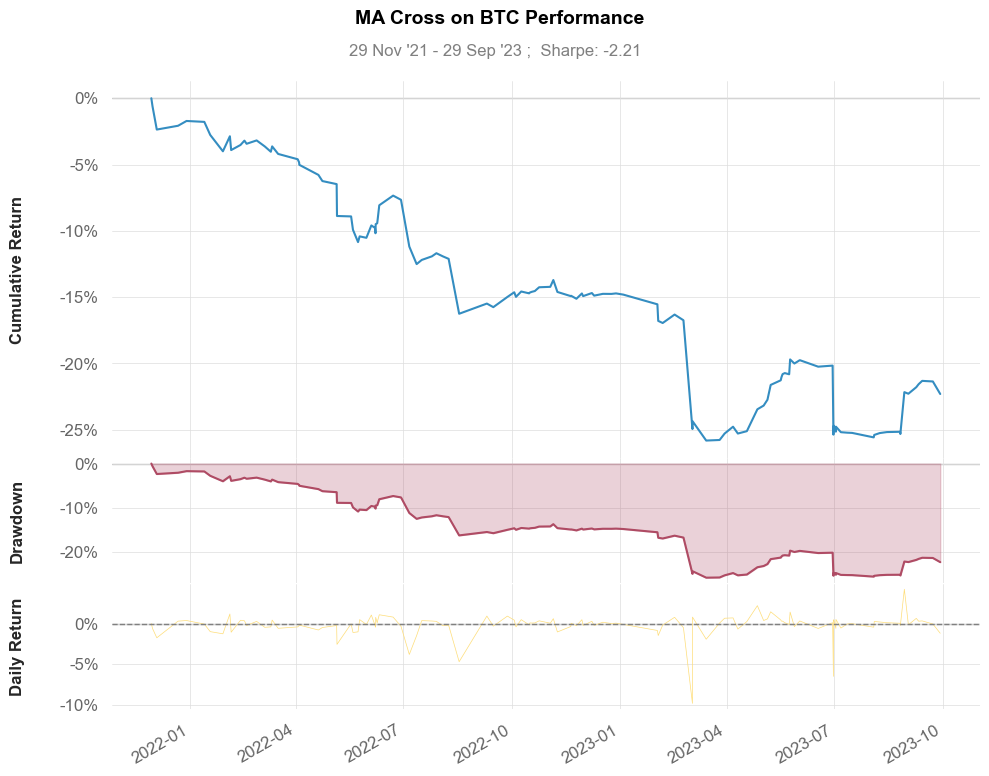

In [11]:
qs.plots.snapshot(position_df['Account Change'], title='MA Cross on BTC Performance', show=True);

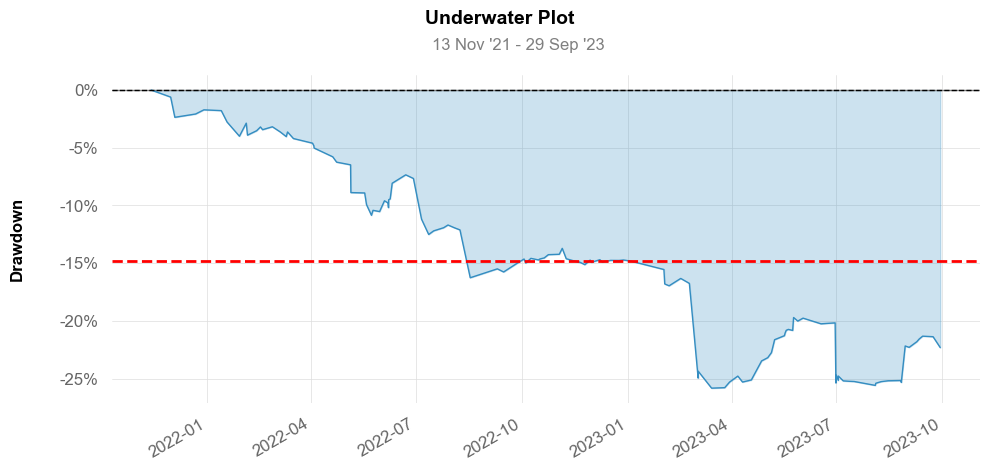

In [12]:
qs.plots.drawdown(position_df['Account Change'])

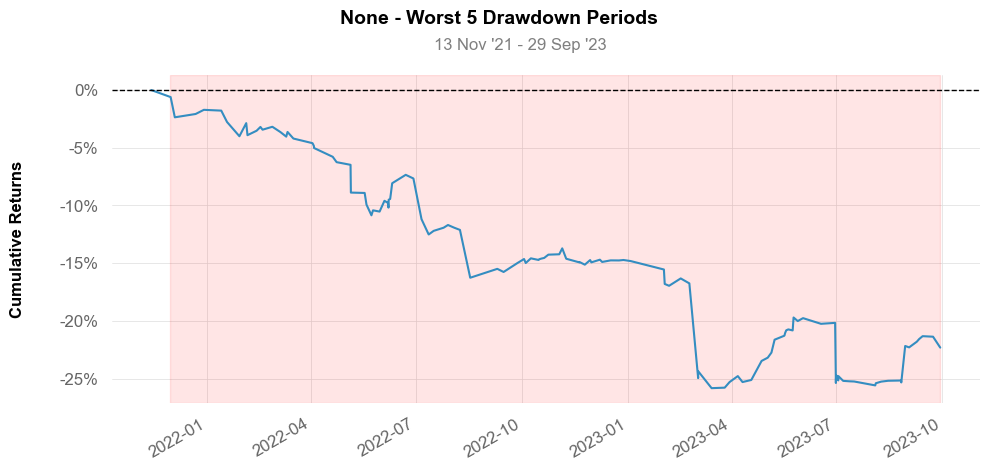

In [13]:
qs.plots.drawdowns_periods(position_df['Account Change'])

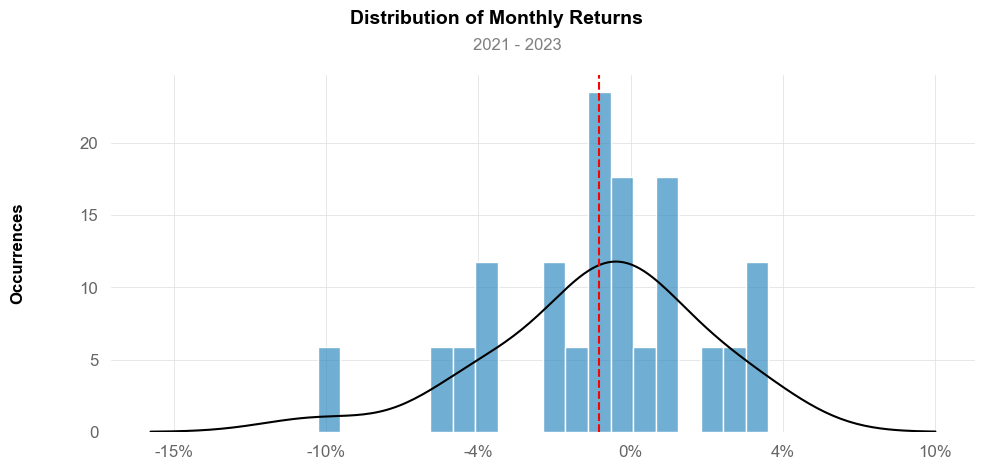

In [14]:
qs.plots.histogram(position_df['Account Change'])

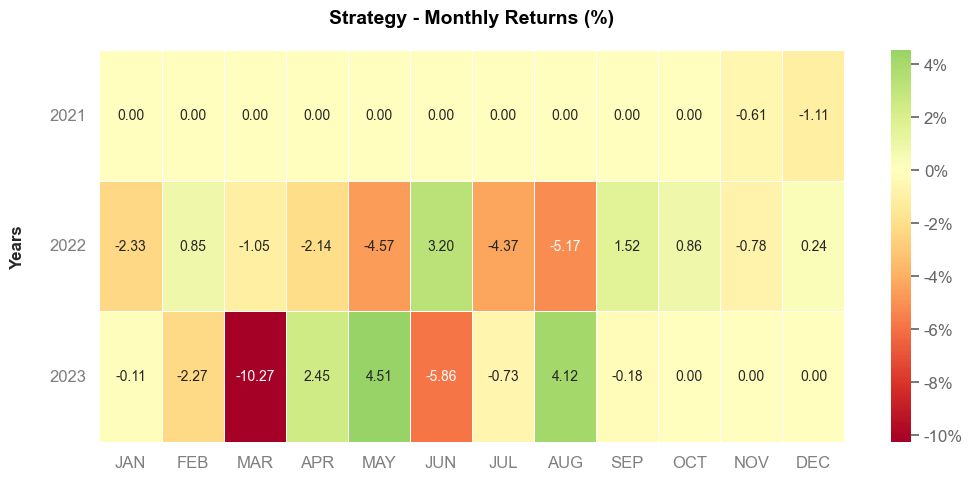

In [15]:
qs.plots.monthly_heatmap(position_df['Account Change'])

In [16]:
qs.stats.sharpe(position_df['Account Change'])

-2.206780751811567